In [1]:
# Matplotlib - 2D plotting library
from matplotlib import pyplot as plt
from matplotlib import rcParams

# Show matplotlib figures inline the notebook
%matplotlib inline

# Pandas - High-performance data analysis
import pandas

# Glob - Unix style pathname pattern expansion
# Used to aggregate folders and files into a single list so they can be iterated over
import glob

# Numpy - For handling of large, multi-dimensional arrays and matrices
import numpy as np

# Scipy - For accurate integration
from scipy.integrate import simps
from scipy.integrate import trapz

##########################################################################################
# Setting rcParams for publication quality graphs
fig_width_pt = 246.0                    # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0      # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # Width in inches
fig_height = fig_width*golden_mean      # Height in inches
fig_size =  [fig_width, fig_height]
fig_size =  [7.3,4.2]
# fig_size =  [7.3*1.5,4.2*1.5]
# fig_size =  [7.3*2,4.2*2]
params = {'backend': 'pdf',
        'axes.labelsize': 10,
        'legend.fontsize': 9,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'xtick.major.size': 6,
        'xtick.major.width': 1,
        'xtick.minor.size': 2.5,
        'xtick.minor.width': 1,
        'ytick.major.size': 6,
        'ytick.major.width': 1,
        'ytick.minor.size': 2.5,
        'ytick.minor.width': 1,
        'font.family': 'times-new-roman',
        'font.sans-serif': 'Times New Roman',
        'font.size': 10,
        'text.usetex': True,
        'figure.figsize': fig_size}

# Update rcParams
rcParams.update(params)

In [2]:
##########################################################################################
# Energy of incident (input) particles
InputEnergies = np.array([np.linspace(100,900, num=9, endpoint=True, dtype = int),
                               ]).flatten()

for i in range(1,8):
    InputEnergies = np.insert(InputEnergies, [i+8], [1000*i])

# Folder containing simulation data
DataFolder = '../G4AdEPTCubeSat_Results/Ar+CS2/Electrons/'

##########################################################################################
# Energy thresholds (in eV) for events that will be included in the analysis
Thr_Gas = 100.
print InputEnergies

[ 100  200  300  400  500  600  700  800  900 1000 2000 3000 4000 5000 6000
 7000]


In [3]:
##########################################################################################
# Load the simulation data for each input energy
Data = []

for InputEnergy in InputEnergies:
    # Create data file template from current energy
    if InputEnergy <= 900.:
        DataFilename = 'e-_' + str(InputEnergy) + 'keV_Nr_1000000000_ISO_nt_G4AdEPTCubeSat_t[0-7].csv'
    else:
        DataFilename = 'e-_' + str(InputEnergy) + 'keV_Nr_100000000_ISO_nt_G4AdEPTCubeSat_t[0-7].csv'

    # Statistics variables for each input energy data
    nPos = 0
    nElec = 0
    nSubPos = 0
    nSubElec = 0
    nTotal = 0
    nSubThr = 0
    nCompton = 0
    nPair = 0
    nPhoto = 0
    nTriton = 0
    
    # Print energy 
    print '\n------------------------------------------------------------'
    print 'Energy: \t\t', str(InputEnergy), 'keV'

    ##########################################################################################
    # Process the simulation data files
    # Column 0 - Total energy deposited in the sensitive gas volume [eV]
    # Column 1 - Energy deposited by positrons in the sensitive gas volume [eV]
    # Column 2 - Energy deposited by positrons in the sensitive gas volume [eV]
    # Column 3 - Energy deposited by tritons in the sensitive gas volume [eV]
    # Column 4 - Track length of particles in the sensitive gas volume [mm]
    # Column 5 - Number of secondary electrons generated in the sensitive gas volume
    # Column 6 - Number of secondary photons generated in the sensitive gas volume
    # Column 7 - Number of secondary positrons generated in the sensitive gas volume
    # Column 8 - Number of secondary tritons generated in the sensitive gas volume
    for dataFile in glob.glob(DataFolder + DataFilename):
        # Readout CSV files
        try:
            dataFrame = pandas.read_csv(dataFile, usecols=[0,1,2,3,4,5,6,7,8], comment="#", error_bad_lines=False, skip_blank_lines=True).values

            # Determine the interaction type
            for i in range(1,len(dataFrame)):
                if dataFrame[i,0] > Thr_Gas:
    #                 if dataFrame[i,8] > 0:
    #                     nTriton += 1
                    if dataFrame[i,7] > 0 and dataFrame[i,5] > 0:
                        nPair += 1
                    else:
                        if dataFrame[i,6] > 0. and dataFrame[i,5] > 0.:
                            nCompton += 1
                        else:
                            nPhoto += 1

            # Increment statistics
            nPos += dataFrame[(dataFrame[:,1] > Thr_Gas),0].size
            nElec += dataFrame[(dataFrame[:,2] > Thr_Gas),0].size
            nSubPos += dataFrame[(dataFrame[:,1] <= Thr_Gas),0].size
            nSubElec += dataFrame[(dataFrame[:,2] <= Thr_Gas),0].size
            nTotal += dataFrame[(dataFrame[:,0] > Thr_Gas),0].size
            nSubThr += dataFrame[(dataFrame[:,0] <= Thr_Gas),0].size
        except:
            pass
    # Add statistics to data list (Convert to numpy array later)
    Data.append([InputEnergy,nPos,nElec,nSubPos,nSubElec,nTotal,nSubThr,nCompton,nPair,nPhoto,nTriton])
        
    # Print statistics
    print '------------------------------------------------------------'
    print 'Number of events above threshold: \t', nTotal
    print 'Number of events below threshold: \t', nSubThr
    print 'Number of Pair Production events: \t', nPair
    print '------------------------------------------------------------'
    
# Convert statistics list to Numpy array
Data = np.asarray(Data)


------------------------------------------------------------
Energy: 		100 keV
------------------------------------------------------------
Number of events above threshold: 	2896
Number of events below threshold: 	8
Number of Pair Production events: 	0
------------------------------------------------------------

------------------------------------------------------------
Energy: 		200 keV
------------------------------------------------------------
Number of events above threshold: 	8591
Number of events below threshold: 	24
Number of Pair Production events: 	0
------------------------------------------------------------

------------------------------------------------------------
Energy: 		300 keV
------------------------------------------------------------
Number of events above threshold: 	15996
Number of events below threshold: 	50
Number of Pair Production events: 	0
------------------------------------------------------------

------------------------------------------------

In [14]:
##########################################################################################
# Calculate the geometry factor (G) assuming an isotropic radiation environment.
# The detector is centered on, and encircled by, a spherical source of radius (R) and
# with N_R simulated particles distributed uniformly along the inner surface.

# Source information (Get this from the Geant4 simulation!!)
# Energies 100 - 900 keV have 1000000000 photons
N_R = 100000000.
N_R_2 = 1000000000.
R = 10.

# Calculate the geometry factors
G_Total_1 = Data[:9,5]/N_R_2*4*(np.pi**2)*(R**2)
G_Total_2 = Data[9:,5]/N_R*4*(np.pi**2)*(R**2)
G_Total = np.array([])
G_Total = np.append(G_Total_1,G_Total_2)

# Calculate the errors for geometry factors 
err_G_Total_1 = 4*(np.pi**2)*(R**2)*np.sqrt((1-Data[:9,5]/N_R_2)*Data[:9,5]/N_R_2**2)
err_G_Total_2 = 4*(np.pi**2)*(R**2)*np.sqrt((1-Data[9:,5]/N_R)*Data[9:,5]/N_R**2)
err_G_Total = np.array([])
err_G_Total = np.append(err_G_Total_1,err_G_Total_2)

# Calculate false positives given by electrons
G_Pair_1 = Data[:9,8]/N_R_2*4*(np.pi**2)*(R**2)
G_Pair_2 = Data[9:,8]/N_R*4*(np.pi**2)*(R**2)
G_Pair = np.array([])
G_Pair = np.append(G_Pair_1,G_Pair_2)

err_G_Pair_1 = 4*(np.pi**2)*(R**2)*np.sqrt((1-Data[:9,8]/N_R_2)*Data[:9,8]/N_R_2**2)
err_G_Pair_2 = 4*(np.pi**2)*(R**2)*np.sqrt((1-Data[9:,8]/N_R)*Data[9:,8]/N_R**2)
err_G_Pair = np.array([])
err_G_Pair = np.append(err_G_Pair_1,err_G_Pair_2)

# Calculate relative errors for the geometry factors
relErr_G_Total = err_G_Total/G_Total
relErr_G_Pair = err_G_Pair/G_Pair

Plot saved to: ../G4AdEPTCubeSat_Results/Ar+CS2/Electrons/Geometric_Factor_Electron.pdf


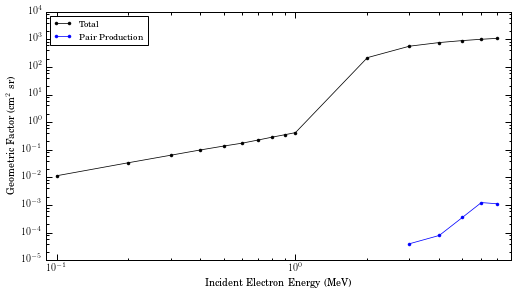

In [15]:
##########################################################################################
# Plot the Geometry Factor over a range of particle energies
figG, axG = plt.subplots(1,1)

plt.loglog(Data[:,0]/1000., G_Total, 'k.-', linewidth=0.75, label='Total')
plt.loglog(Data[:,0]/1000., G_Pair, 'b.-', linewidth=0.75, label='Pair Production')

# Figure Properties
axG.set_ylabel(r'Geometric Factor (cm$^2$ sr)')  
axG.set_xlabel('Incident Electron Energy (MeV)') 
# axG.set_ylim(0.01, 2000.)
axG.set_xlim(0.09, 8)

axG.legend(loc='upper left')

# Tight Layout
plt.tight_layout()

# Save the figure 
file_figG = 'Geometric_Factor_Electron.pdf'
plt.savefig(DataFolder + file_figG, bbox_inches="tight")
print 'Plot saved to: ' + (DataFolder+file_figG)

# Show the figure
plt.show(figG)

Plot saved to: ../G4AdEPTCubeSat_Results/Ar+CS2/Electrons/Geometric_Factor_Error_Electron.pdf


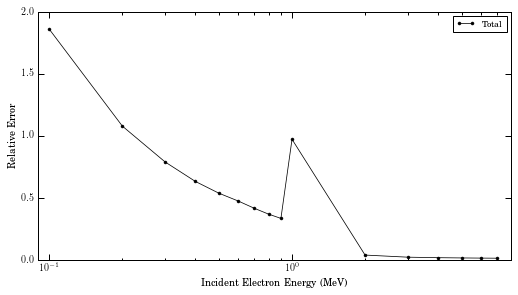

In [16]:
##########################################################################################
# Plot the error in the Geometry Factor over a range of particle energies
figE, axE = plt.subplots(1,1)

plt.semilogx(Data[:,0]/1000., relErr_G_Total*100., 'k.-', linewidth=0.75, label="Total")

# Figure Properties
axE.set_ylabel(r'Relative Error')  
axE.set_xlabel('Incident Electron Energy (MeV)') 
# axE.set_ylim(0., 0.05)
axE.set_xlim(0.09, 8)

axE.legend(loc='upper right')

# Tight Layout
plt.tight_layout()

# Save the figure 
file_figE = 'Geometric_Factor_Error_Electron.pdf'
plt.savefig(DataFolder + file_figE, bbox_inches="tight")
print 'Plot saved to: ' + (DataFolder+file_figE)

# Show the figure
plt.show(figE)

Plot saved to: ../G4AdEPTCubeSat_Results/Ar+CS2/Electrons/Electron_Flux.pdf


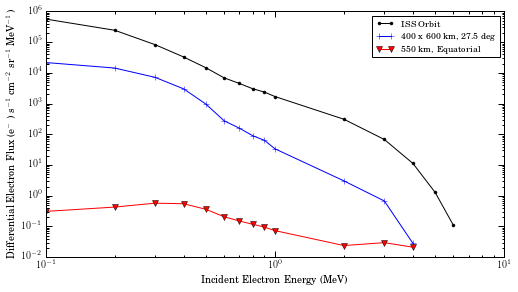

In [17]:
fluxData = []
fluxDataFile = '../G4AdEPTCubeSat_Results/Ar+CS2/Electrons/Trapped_Electron_Flux.csv'
fluxDataFrame = pandas.read_csv(fluxDataFile, usecols=[1], comment='#',header=-1,dtype='float').values
fluxData = fluxDataFrame.flatten()

fluxData2 = []
fluxDataFile2 = '../G4AdEPTCubeSat_Results/Ar+CS2/Electrons/Trapped_Electron_Flux_400x600.csv'
fluxDataFrame2 = pandas.read_csv(fluxDataFile2, usecols=[1], comment='#',header=-1,dtype='float').values
fluxData2 = fluxDataFrame2.flatten()

fluxData3 = []
fluxDataFile3 = '../G4AdEPTCubeSat_Results/Ar+CS2/Electrons/Trapped_Electron_Flux_eq.csv'
fluxDataFrame3 = pandas.read_csv(fluxDataFile3, usecols=[1], comment='#',header=-1,dtype='float').values
fluxData3 = fluxDataFrame3.flatten()

figF, axF = plt.subplots(1,1)

plt.loglog(InputEnergies/1000.,fluxData,'k.-',label="ISS Orbit")
plt.loglog(InputEnergies/1000.,fluxData2,'b+-',label="400 x 600 km, 27.5 deg")
plt.loglog(InputEnergies/1000.,fluxData3,'rv-',label="550 km, Equatorial")

axF.set_ylabel(r'Differential Electron Flux (e$^{-}$ s$^{-1}$ cm$^{-2}$ sr$^{-1}$ MeV$^{-1}$)')
axF.set_xlabel('Incident Electron Energy (MeV)')
# axF.set_ylim(1e-2, 1e6)
plt.tight_layout()

axF.legend(loc='upper right')

# Save the figure 
file_figF = 'Electron_Flux.pdf'
plt.savefig(DataFolder + file_figF, bbox_inches="tight")
print 'Plot saved to: ' + (DataFolder+file_figF)

plt.show(figF)

Plot saved to: ../G4AdEPTCubeSat_Results/Ar+CS2/Electrons/Electron_Differential_Count_Rate.pdf


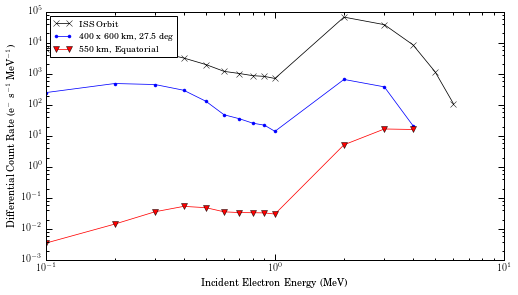

In [18]:
diffCountRate1 = G_Total*fluxData
diffCountRate2 = G_Total*fluxData2
diffCountRate3 = G_Total*fluxData3
diffCountRate_Pair1 = G_Pair*fluxData
diffCountRate_Pair2 = G_Pair*fluxData2
diffCountRate_Pair3 = G_Pair*fluxData3
figD, axD = plt.subplots(1,1)

plt.loglog(InputEnergies/1000.,diffCountRate1,'kx-',linewidth=0.75,label='ISS Orbit')
plt.loglog(InputEnergies/1000.,diffCountRate2,'b.-',linewidth=0.75,label='400 x 600 km, 27.5 deg')
plt.loglog(InputEnergies/1000.,diffCountRate3,'rv-',linewidth=0.75,label='550 km, Equatorial')
# plt.loglog(InputEnergies/1000.,diffCountRate_Pair,'b.-',linewidth=0.75,label='Pair Production')

axD.set_ylabel(r'Differential Count Rate (e$^{-}$ s$^{-1}$ MeV$^{-1}$)')
axD.set_xlabel('Incident Electron Energy (MeV)')
# axD.set_xlim(1e0,1e1)

plt.tight_layout()

axD.legend(loc='upper left')

file_figD = 'Electron_Differential_Count_Rate.pdf'
plt.savefig(DataFolder + file_figD, bbox_inches="tight")
print 'Plot saved to: ' + (DataFolder+file_figD)

plt.show(figD)

In [19]:
##########################################################################################
### False Positive Counts

intCountRate_trial = simps(diffCountRate_Pair1) 

# Simpson's Method
Energies_MeV = InputEnergies/1000.
intFalseRate1 = np.array([])
intFalseRate2 = np.array([])
intFalseRate3 = np.array([])

Counts = 0
for i in range(0,len(InputEnergies)-1):    # Modified Simpson's rule with variable energy spacing
    dE = Energies_MeV[i+1]-Energies_MeV[i]
    Counts = trapz(diffCountRate_Pair1[i:i+2],dx=dE)# Energies_MeV[i:i+2])# # Using dE or Energies_MeV gives the same answer
    intFalseRate1 = np.append(intFalseRate1,Counts)

Counts = 0
for i in range(0,len(InputEnergies)-1):    # Modified Simpson's rule with variable energy spacing
    dE = Energies_MeV[i+1]-Energies_MeV[i]
    Counts = trapz(diffCountRate_Pair2[i:i+2],dx=dE)# Energies_MeV[i:i+2])# # Using dE or Energies_MeV gives the same answer
    intFalseRate2 = np.append(intFalseRate2,Counts)

Counts = 0
for i in range(0,len(InputEnergies)-1):    # Modified Simpson's rule with variable energy spacing
    dE = Energies_MeV[i+1]-Energies_MeV[i]
    Counts = trapz(diffCountRate_Pair3[i:i+2],dx=dE)# Energies_MeV[i:i+2])# # Using dE or Energies_MeV gives the same answer
    intFalseRate3 = np.append(intFalseRate3,Counts)
    
intFalseRate1 = sum(intFalseRate1)
intFalseRate2 = sum(intFalseRate2)
intFalseRate3 = sum(intFalseRate3)

##########################################################################################
# Average Energy Method
def effEnergy(Energy1,Energy2):
    effEnergy1 = np.log(Energy2/Energy1)/(1./Energy1-1./Energy2)
    effEnergy2 = 1./((effEnergy1**2)*(1./Energy1-1./Energy2))
    return effEnergy1,effEnergy2    # effEnergy1 = 1./(<E>^2 * (1/E1 - 1/E2)

inEnergy1 = 1.*Energies_MeV[0:len(Energies_MeV)-1]
inEnergy2 = 1.*Energies_MeV[1:len(Energies_MeV)]

[effecEnergy1,effecEnergy2] = effEnergy(inEnergy1,inEnergy2)    # <E>

diffFalseRate_1 = diffCountRate_Pair1[0:15]/effecEnergy2
diffFalseRate_2 = diffCountRate_Pair2[0:15]/effecEnergy2
diffFalseRate_3 = diffCountRate_Pair3[0:15]/effecEnergy2

revDiffFalseRate_1 = diffFalseRate_1[::-1]
revDiffFalseRate_2 = diffFalseRate_2[::-1]
revDiffFalseRate_3 = diffFalseRate_3[::-1]

intFalseRate_1 = np.array([])
intFalseRate_2 = np.array([])
intFalseRate_3 = np.array([])

counts = 0
for i in range(0,len(diffFalseRate_1)):
    counts = sum(revDiffFalseRate_1[0:i])
    intFalseRate_1 = np.append(intFalseRate_1, counts)
    
counts = 0
for i in range(0,len(diffFalseRate_2)):
    counts = sum(revDiffFalseRate_2[0:i])
    intFalseRate_2 = np.append(intFalseRate_2, counts)
    
counts = 0
for i in range(0,len(diffFalseRate_3)):
    counts = sum(revDiffFalseRate_3[0:i])
    intFalseRate_3 = np.append(intFalseRate_3, counts)
    
intFalseRate_1 = intFalseRate_1[::-1]
intFalseRate_2 = intFalseRate_2[::-1]
intFalseRate_3 = intFalseRate_3[::-1]

##########################################################################################
##########################################################################################
### Electron Counts
# Simpson's method
intCountRate1 = np.array([])
intCountRate2 = np.array([])
intCountRate3 = np.array([])

Counts = 0
for i in range(0,len(InputEnergies)-1):    # Modified Simpson's rule with variable energy spacing
    dE = Energies_MeV[i+1]-Energies_MeV[i]
    Counts = trapz(diffCountRate1[i:i+2],dx=dE)# Energies_MeV[i:i+2])# # Using dE or Energies_MeV gives the same answer
    intCountRate1 = np.append(intCountRate1,Counts)

Counts = 0
for i in range(0,len(InputEnergies)-1):    # Modified Simpson's rule with variable energy spacing
    dE = Energies_MeV[i+1]-Energies_MeV[i]
    Counts = trapz(diffCountRate2[i:i+2],dx=dE)# Energies_MeV[i:i+2])# # Using dE or Energies_MeV gives the same answer
    intCountRate2 = np.append(intCountRate2,Counts)

Counts = 0
for i in range(0,len(InputEnergies)-1):    # Modified Simpson's rule with variable energy spacing
    dE = Energies_MeV[i+1]-Energies_MeV[i]
    Counts = trapz(diffCountRate3[i:i+2],dx=dE)# Energies_MeV[i:i+2])# # Using dE or Energies_MeV gives the same answer
    intCountRate3 = np.append(intCountRate3,Counts)

intCountRate1_Simp = sum(intCountRate1)
intCountRate2_Simp = sum(intCountRate2)
intCountRate3_Simp = sum(intCountRate3)

##########################################################################################
# Average Energy Method
diffCountRate_1 = diffCountRate1[0:15]/effecEnergy2
diffCountRate_2 = diffCountRate2[0:15]/effecEnergy2
diffCountRate_3 = diffCountRate3[0:15]/effecEnergy2

revDiffCountRate_1 = diffCountRate_1[::-1]
revDiffCountRate_2 = diffCountRate_2[::-1]
revDiffCountRate_3 = diffCountRate_3[::-1]

intCountRate_1 = np.array([])
intCountRate_2 = np.array([])
intCountRate_3 = np.array([])

counts = 0
for i in range(0,len(diffCountRate_1)):
    counts = sum(revDiffCountRate_1[0:i])
    intCountRate_1 = np.append(intCountRate_1, counts)
    
counts = 0
for i in range(0,len(diffCountRate_2)):
    counts = sum(revDiffCountRate_2[0:i])
    intCountRate_2 = np.append(intCountRate_2, counts)
    
counts = 0
for i in range(0,len(diffCountRate_3)):
    counts = sum(revDiffCountRate_3[0:i])
    intCountRate_3 = np.append(intCountRate_3, counts)
    
intCountRate_1 = intCountRate_1[::-1]
intCountRate_2 = intCountRate_2[::-1]
intCountRate_3 = intCountRate_3[::-1]

# ##########################################################################################
# # Calculate the count rate error from Simpson's Method
# low_G_Pair = G_Pair - err_G_Pair
# high_G_Pair = G_Pair + err_G_Pair
# diffCountRateErrorLow = low_G_Pair*fluxData
# diffCountRateErrorHigh = high_G_Pair*fluxData

# # Lowest possible counts
# Counts = 0
# dE = 0
# intCountRateErrorLow = np.array([])

# for i in range(0,len(InputEnergies)-1):    # Modified Simpson's rule with variable energy spacing
#     dE = Energies_MeV[i+1]-Energies_MeV[i]
#     Counts = trapz(diffCountRateErrorLow[i:i+2],dx=dE)# Energies_MeV[i:i+2])# # Using dE or Energies_MeV gives the same answer
#     intCountRateErrorLow = np.append(intCountRateErrorLow,Counts)

# intCountRateErrorLow = sum(intCountRateErrorLow)    
    
# # Highest possible counts
# Counts = 0
# dE = 0
# intCountRateErrorHigh = np.array([])

# for i in range(0,len(InputEnergies)-1):    # Modified Simpson's rule with variable energy spacing
#     dE = Energies_MeV[i+1]-Energies_MeV[i]
#     Counts = trapz(diffCountRateErrorHigh[i:i+2],dx=dE)# Energies_MeV[i:i+2])# # Using dE or Energies_MeV gives the same answer
#     intCountRateErrorHigh = np.append(intCountRateErrorHigh,Counts)
    
# intCountRateErrorHigh = sum(intCountRateErrorHigh)

# intCountRateError = (intCountRateErrorHigh-intCountRateErrorLow)/2

# ##########################################################################################
# # Calculate the count rate error from Average Energy Method

# counts = 0
# inEnergy1 = 1.*Energies_MeV[0:len(Energies_MeV)-1]
# inEnergy2 = 1.*Energies_MeV[1:len(Energies_MeV)]

# [effecEnergy1,effecEnergy2] = effEnergy(inEnergy1,inEnergy2)    # <E>

# # Lowest possible count rate
# diffCountRateErrorAvgLow = diffCountRateErrorLow[0:15]/effecEnergy2
# revDiffCountRateErrorAvgLow = diffCountRateErrorAvgLow[::-1]
# intCountRateErrorAvgLow = np.array([])

# for i in range(0,len(diffCountRate)):
#     counts = sum(revDiffCountRateErrorAvgLow[0:i])
#     intCountRateErrorAvgLow = np.append(intCountRateErrorAvgLow, counts)
    
# intCountRateErrorAvgLow = intCountRateErrorAvgLow[::-1]

# # Highest Possible count rate
# diffCountRateErrorAvgHigh = diffCountRateErrorHigh[0:15]/effecEnergy2
# revDiffCountRateErrorAvgHigh = diffCountRateErrorAvgHigh[::-1]
# intCountRateErrorAvgHigh = np.array([])

# for i in range(0,len(diffCountRate)):
#     counts = sum(revDiffCountRateErrorAvgHigh[0:i])
#     intCountRateErrorAvgHigh = np.append(intCountRateErrorAvgHigh, counts)
    
# intCountRateErrorAvgHigh = intCountRateErrorAvgHigh[::-1]


# intCountRateErrorAvg = (max(intCountRateErrorAvgHigh)-max(intCountRateErrorAvgLow))/2

# print intCountRate*60*92.6318
# print intCountRate_trial*60*92.6318
# print intCountRate1*60*92.6318
# print "Predicted count rate of", max(intCountRate_Pair1)*60*92.6318, "+/- ", intCountRateErrorAvg*60*92.6318, "false positives/orbit by Average Energy Method."
# print "Predicted count rate of", intFalseRate1*60*92.6318," +/- ", intCountRateError*60*92.6318, "false positives/orbit by Modified Simpson's Rule."
# print "Predicted count rate of", max(intCountRate_Pair1)*60*60*24*365," +/- ", intCountRateErrorAvg*60*60*24*365, "false positives/year by Average Energy Method."
# print "Predicted count rate of", intFalseRate1*60*60*24*365," +/- ", intCountRateError*60*60*24*365, "false positives/year by Modified Simpson's Rule."

print "In ISS orbit: \t\t\t", max(intCountRate_1)*60*92.6318, " detections/orbit and ", max(intFalseRate_1)*60*92.6318, " false positives per orbit" 
print "In 400x600 km, 27.5 deg orbit: \t", max(intCountRate_2)*60*94, " detections/orbit and ", max(intFalseRate_2)*60*92.6318, " false positives per orbit" 
print "In 550 km, 0 deg orbit: \t", max(intCountRate_3)*60*95, " detections/orbit and ", max(intFalseRate_3)*60*92.6318, " false positives per orbit" 

In ISS orbit: 			646326163.178  detections/orbit and  22.9704144068  false positives per orbit
In 400x600 km, 27.5 deg orbit: 	6821729.42995  detections/orbit and  0.15966739321  false positives per orbit
In 550 km, 0 deg orbit: 	215874.278113  detections/orbit and  0.0157759916522  false positives per orbit
